<a href="https://colab.research.google.com/github/tyoc213/fastai_xla_extensions/blob/master/explore_nbs/Basic_lenet_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install fastai2 from github

In [1]:
!pip uninstall -y fastai fastai2 fastcore

Uninstalling fastai-2.0.2:
  Successfully uninstalled fastai-2.0.2
Uninstalling fastcore-1.0.1:
  Successfully uninstalled fastcore-1.0.1


In [2]:
VERSION = "20200707"  #"20200515" @param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  91339      0 --:--:-- --:--:-- --:--:-- 91339


In [3]:
#!TORCH_SHOW_CPP_STACKTRACES=1 python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
!python pytorch-xla-env-setup.py  --version $VERSION --apt-packages libomp5 libopenblas-dev

Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200707 ...
Uninstalling torch-1.6.0:
  Successfully uninstalled torch-1.6.0
Uninstalling torchvision-0.7.0:
  Successfully uninstalled torchvision-0.7.0
Copying gs://tpu-pytorch/wheels/torch-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
- [1 files][107.5 MiB/107.5 MiB]                                                
Operation completed over 1 objects/107.5 MiB.                                    
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
\ [1 files][123.8 MiB/123.8 MiB]                                                
Operation completed over 1 objects/123.8 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
/ [1 files][  2.2 MiB/  2.2 MiB]                                                
Operation completed over 1 objects/2.2 MiB.                                      
Processin

In [22]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm

In [5]:
!pip install git+https://github.com/fastai/fastcore
!pip install git+https://github.com/fastai/fastai

  Cloning https://github.com/fastai/fastcore to /tmp/pip-req-build-hub8sk2b
  Running command git clone -q https://github.com/fastai/fastcore /tmp/pip-req-build-hub8sk2b
  Created wheel for fastcore: filename=fastcore-1.0.1-cp36-none-any.whl size=36911 sha256=29402479a22fa248ec9f9ecf6792b8a27bfb7d2d1abac6306a1eaedfb5b2f866
  Stored in directory: /tmp/pip-ephem-wheel-cache-rjehpy0s/wheels/8a/2a/23/bc50c8f5e28776b44ac837a01fcfa675724565d4813d8e51c7
Successfully built fastcore
  Cloning https://github.com/fastai/fastai to /tmp/pip-req-build-wacu697c
  Running command git clone -q https://github.com/fastai/fastai /tmp/pip-req-build-wacu697c
  Created wheel for fastai: filename=fastai-2.0.2-cp36-none-any.whl size=182227 sha256=7cdc349a38667d402296708cf68e1bad01eef3833bd5ae67946c8b03a96b6cbd
  Stored in directory: /tmp/pip-ephem-wheel-cache-4roe09pb/wheels/83/30/a0/6fa8a74c9f5a5ab45cdc84e9f9ed56d8a72750e11ebf50a364
Successfully built fastai


In [23]:
from fastai.vision.all import *

In [24]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()[2].ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/3'),Path('/root/.fastai/data/mnist_sample/train/7')]

In [25]:
def get_my_labels(fname):
    return int(fname.parent.name[0])

dblock = DataBlock(
    splitter = RandomSplitter(),
    #item_tfms = Resize(128),
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = get_my_labels
)


In [26]:
dls_normal = dblock.dataloaders(path)
dls_normal.vocab

(#2) [3,7]

# Lenet with convs and F.max_pool2d

In [27]:
class MyLenet(nn.Module):
    def __init__(self):
        super(MyLenet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6,16,3)
        self.hiden4 = nn.Linear(400, 2) # 2 outputs instead of 10
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.hiden4(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

lenet = MyLenet()
learn = Learner(dls_normal, lenet, metrics=[error_rate, accuracy])



In [28]:
%%time
learn.fit_one_cycle(1)
learn.validate()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.092843,0.051645,0.016979,0.983021,00:17


(#3) [0.05164510756731033,0.016978517174720764,0.9830214977264404]

# Lenet with layers

In [29]:
class Lenet2(nn.Module):
    def __init__(self):
        super(Lenet2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2) # Only 2 outputs instead of 10
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features



lenet2 = Lenet2()
learn2 = Learner(dls_normal, lenet2, metrics=[error_rate, accuracy])



In [30]:
%%time
learn2.fit_one_cycle(1)
learn.validate()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.060191,0.034106,0.009009,0.990991,00:14


(#3) [0.05164510756731033,0.016978517174720764,0.9830214977264404]

# Current TPU implementation callbacks

In [31]:
#export
class XLAOptimProxy:
    "Proxy optimizer to override `opt.step` with Pytorch XLA sync method `xm.optimizer_step` "  
    def __init__(self,opt, barrier=True):
        print("XLAOptimProxy#__init__")
        self.opt = opt
        self._barrier = barrier
        
    def xla_step(self):
        print("XLAOptimProxy#xla_step")
        xm.optimizer_step(self.opt,barrier=self._barrier) # sync on gradient update
        
    def __getattr__(self,name):
        if name == 'step': # override proxying for step
            return getattr(self,'xla_step')
        if name in ('barrier','_barrier'):
            return getattr(self,name)
      
        # proxy everything else
        return getattr(self.opt,name)
    @property
    def barrier(self): return self._barrier
    @barrier.setter
    def barrier(self,v): self._barrier = v 

In [33]:
#export
from fastai.callback.core import Callback

class XLAOptCallback(Callback):
    'Callback to replace `opt.step` with `xm.optimizer_step(opt)` as required to run on TPU'
    def __init__(self, barrier=True):
        print("XLAOptCallback#__init__")
        self._barrier = barrier
  
    def before_fit(self):
        'replace opt with proxy which calls `xm.optimizer_step` instead of `opt.step`'
        print("XLAOptCallback#before_fit")
        if self.learn.opt is not None:
            if not isinstance(self.learn.opt,XLAOptimProxy):
                opt = self.learn.opt
                self.learn.opt = XLAOptimProxy(opt, barrier=self._barrier)
                
    def after_fit(self):
        'restore original opt '
        print("XLAOptCallback#after_fit")
        if isinstance(self.learn.opt, XLAOptimProxy):
            opt = self.learn.opt.opt
            self.learn.opt = opt
    @property
    def barrier(self): return self._barrier
    @barrier.setter
    def barrier(self,v): self._barrier = v

# Load in TPU

In [34]:
dblock.summary(path)

Setting-up type transforms pipelines
Found 14434 items
2 datasets of sizes 11548,2886
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_my_labels -> Categorize -- {'vocab': (#2) [3,7], 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_sample/train/3/38445.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: get_my_labels -> Categorize -- {'vocab': (#2) [3,7], 'add_na': False}
    starting from
      /root/.fastai/data/mnist_sample/train/3/38445.png
    applying get_my_labels gives
      3
    applying Categorize -- {'vocab': (#2) [3,7], 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(0))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

Building one batch
Applying item_tfms to the first sample:
  Pipeline: To

# Use TPU device

In [35]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm


# Aquire a TPU device

(None, (#2) [3,7])

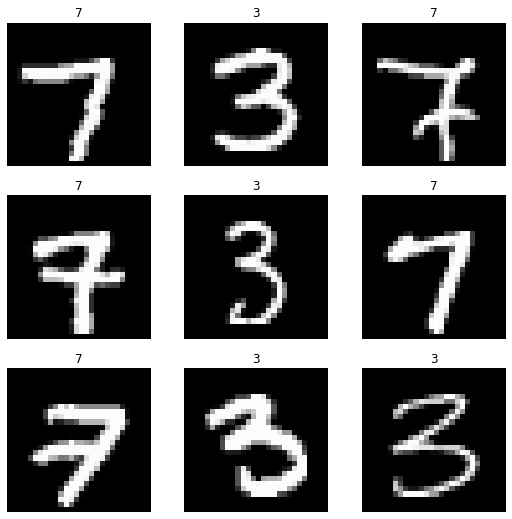

In [36]:

dede = xm.xla_device()
dls_tpu = dblock.dataloaders(path, device=dede)
dls_tpu.show_batch(), dls_tpu.vocab

In [37]:
dls_tpu.show([1])

In [38]:
#sgd_xla_opt = XLAOptFuncWrapper(SGD)
#adam_xla_opt = XLAOptFuncWrapper(Adam)


## First training on TPU

In [39]:
# from fastai.callback.all import *
from fastai.test_utils import *
lenet_tpu = Lenet2()
tpu_learner = Learner(dls_tpu,
                      lenet_tpu,
                      device=dede,
                      metrics=accuracy, 
                      loss_func=F.cross_entropy,
                      cbs=[XLAOptCallback()])

XLAOptCallback#__init__


In [40]:
tpu_learner.summary()

XLAOptCallback#before_fit


XLAOptCallback#after_fit


Lenet2 (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 6 x 26 x 26     168        True      
________________________________________________________________
Conv2d               64 x 16 x 11 x 11    880        True      
________________________________________________________________
Linear               64 x 120             48,120     True      
________________________________________________________________
Linear               64 x 84              10,164     True      
________________________________________________________________
Linear               64 x 2               170        True      
________________________________________________________________

Total params: 59,502
Total trainable params: 59,502
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fe83e718ea0>
Loss function: <function cross_entropy at 0x7fe85c3d48c8>

Callbacks:
  - TrainEvalCallback
  - Recorder
  - Progr

In [41]:
tpu_learner.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, XLAOptCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - after_backward : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch 

In [42]:
dls_tpu.device

device(type='xla', index=1)

# Call fit

Will fail in `self.loss.backward(); `?

In [43]:
tpu_learner.fit(1)

XLAOptCallback#before_fit
XLAOptimProxy#__init__


epoch,train_loss,valid_loss,accuracy,time
0,0.054927,0.037162,0.986486,00:18


XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimPro

XLAOptCallback#before_fit
XLAOptimProxy#__init__


XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimProxy#xla_step
XLAOptimPro

SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=6.309573450380412e-07)

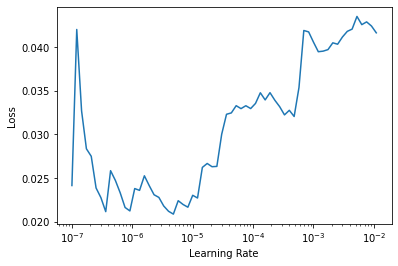

In [44]:
tpu_learner.lr_find()

reference for https://pytorch.org/docs/stable/autograd.html#torch.autograd.backward

In [45]:
ob = tpu_learner.dls.train.one_batch()
#print(ob)
len(ob), ob[0].shape, ob[1].shape, F.cross_entropy, tpu_learner.pred

(2,
 torch.Size([64, 3, 28, 28]),
 torch.Size([64]),
 <function torch.nn.functional.cross_entropy>,
 None)

In [46]:
#the_loss = tpu_learner.loss_func(tpu_learner.pred, *tpu_learner.yb)
the_loss = tpu_learner.loss_func(tpu_learner.dls, *tpu_learner.yb)

AttributeError: ignored